In [1]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1) # log(softmax(x))   log(Softmax(x)) 
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x


In [4]:
# debug 

model = BobNet()
#dir(model.parameters())
print(type(model.parameters())) # 返回的是一个generator

for para in model.parameters():
    print(para.size()) # 只查看形状
    
BS = 128
print(X_train.shape)
print(X_train.shape[0])
samp = np.random.randint(0, X_train.shape[0], size=(BS))
print(samp)
print(samp.shape)
print(X_train)
print(X_train.shape)
X_train[samp]

list2 = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x = np.maximum(list2, 3)
print(x)
list2=np.array(list2)
test = np.random.randint(1, 10, size=(2))
print(test)
print(list2[test])
# test = [1 4],  list2[test] = [2 5] get the number of position 1, and 4 in the array np.(list2)

samp = np.random.randint(0, X_train.shape[0], size=(BS))
X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
Y = torch.tensor(Y_train[samp]).long()
model.zero_grad() #模型中参数的梯度设为0
out = model(X)
cat = torch.argmax(out, dim=1)

print(out)
print(out.shape)
print(cat)
print(cat.shape)
accuracy = (cat == Y).float().mean()
print(accuracy)
print(accuracy.shape)
accuracy = accuracy.item()
print(accuracy)
#print(accuracy.shape)

<class 'generator'>
torch.Size([128, 784])
torch.Size([10, 128])
(60000, 28, 28)
60000
[25930 10590 45972 35972  3537 22178 35930 42496 36656 16313  6226 28018
 13742 58573 51694 20403 21458 18920 48067 34624 52658 32859 45134  4213
  9989 28255 48784 44891 47414 21141 39173 29128 10231 41070 41435 55478
 54840 32200 54207 58305 15166 52685 32709 11960 37175 54182 12310 53141
 46433 32131 43727 51578 53785 21189  5541 25338 41605 40540 55719 12504
 50322 53129 38293 23316 35042 52736 18186 14830  9749 32907 30998 15548
  4549 17133 17883 56050 32339 14570 55324  6031  7367 33038 25690 22575
 56528  9223 11954  8533 59228 57413  8701 11235  1450 31839 20313 28757
  5904  7264 39546 18981 24763 31136  2792 57322 31923 41356 52379 13533
 27700 45443 12353 49848 14429 57803 41166 28272  9372 46681 37908 56757
 29568  5423 57805 44995 28390 14094 16383  9135]
(128,)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

loss 0.36 accuracy 0.90: 100%|██████████| 1000/1000 [00:02<00:00, 418.95it/s]


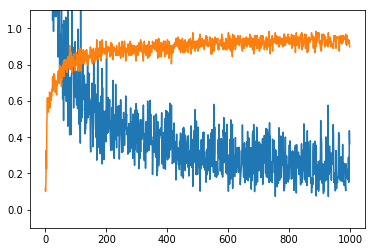

In [5]:
# training
model = BobNet()

# protip: if you like accuracy like 96 not like 93, next time through the notebook, consider
# CHAD MODE WEIGHT INIT WITH NUMPY
# instead of virgin torch init mode
# TODO: why is torch linear init bad?
"""
with torch.no_grad():
  model.l1.weight.copy_(torch.tensor(layer_init(784, 128).T))
  model.l2.weight.copy_(torch.tensor(layer_init(128, 10).T))
"""

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
t = trange(1000)
for i in (t):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad() #模型中参数的梯度设为0
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [6]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9266

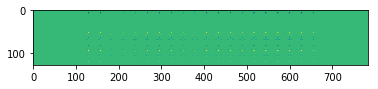

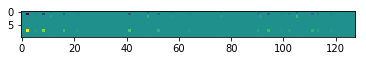

In [7]:
# compute gradients in torch
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

In [8]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

print(l1.shape)
print(l2.shape)
# numpy forward pass
def forward(x):
  print(x.shape)
  x = x.dot(l1)
  print(x.shape)
  x = np.maximum(x, 0)
  print(x.shape)
  x = x.dot(l2)  
  print(x.shape)
  return x

def numpy_eval():
  Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
  Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
  return (Y_test == Y_test_preds).mean()

(784, 128)
(128, 10)
(10000, 784)
(10000, 128)
(10000, 128)
(10000, 10)


0.9266

In [10]:
# numpy forward and backward pass
# solve under- or overflow when exponentiating large values
def logsumexp(x):
  #return np.log(np.exp(x).sum(axis=1))
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  c = x.max(axis=1)
  return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

#>>> x = np.array([-1000, -1000, -1000])
#>>> np.exp(x)
#array([0., 0., 0.])
#>>> np.exp(x - logsumexp(x))
#array([0.33333333, 0.33333333, 0.33333333])numpy_eval()

samp = [0,1,2,3]
x, y = X_test[samp].reshape((-1, 28*28)), Y_test[samp]
out  = np.zeros((len(y),10), np.float32)

'''
print(out)
print(out.shape)
out[range(out.shape[0]),y] = 1
print(out.shape[0])
print(range(out.shape[0]))
print(y)
print(out)
'''

t1 = np.array([1,2,3])
t2 = np.array([2,1,3])

print(t1 * t2)


samp = [0,1,2,3]
x, y = X_test[samp].reshape((-1, 28*28)), Y_test[samp]
out  = np.zeros((len(y),10), np.float32)

'''
# forward pass
print(x.shape) #x(4, 784)
print(l1.shape)#l1(784, 128)
x_l1 = x.dot(l1)
print(x_l1.shape)#x_l1(4, 128)
x_relu = np.maximum(x_l1, 0)
print(x_relu.shape)#x_relu(4, 128)
x_l2 = x_relu.dot(l2)
print(l2.shape)#x_l2(128, 10)
print(x_l2.shape)#x_l2(4, 10)
x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))

print(logsumexp(x_l2))
print(logsumexp(x_l2).shape)#x_l2(4, 10)
print(logsumexp(x_l2).reshape((-1, 1)))
print(logsumexp(x_l2).reshape((-1, 1)).shape)
#[23.721836 19.296984 14.008053 18.097654]
#(4,)
#[[23.721836]
# [19.296984]
# [14.008053]
# [18.097654]]
#(4, 1)

print(x_lsm.shape)#x_lsm(4, 10)
print(out.shape)#out(4, 10)
x_loss = (-out * x_lsm).mean(axis=1)
print(x_loss.shape)#x_loss(4,)
print(x_loss)

class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1) # log(softmax(x))   log(Softmax(x)) 
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

softmax = e^{…} / [sum_k e^{…, class_k, …}]



logsoftmax = log(e^{…}) - log [sum_k e^{…, class_k, …}]
logsoftmax = logits - log(reduce_sum(exp(logits), axis))

log(reduce_sum(exp(logits), axis)) = return np.log(np.exp(x).sum(axis=1))

logits	A non-empty Tensor. Must be one of the following types: half, float32, float64.

'''

# forward pass
x_l1 = x.dot(l1)
x_relu = np.maximum(x_l1, 0)
x_l2 = x_relu.dot(l2)
x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1)) 
x_loss = (-out * x_lsm).mean(axis=1)

d_out = -out / len(y)
'''
print("--------------")
print(out)
print(y)
print(len(y))
print(d_out)
test = [[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]]

print(d_out.sum(axis=0))
print(d_out.sum(axis=1))
'''


# derivative of logsoftmax
# https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
'''
  for (t = 0; t < stride*nframe; t++)
  {
    sum = 0;
    gradInput_data = gradInput_data0 + (t/stride)*dim*stride + t % stride;      # gradInput_data  => dx_lsm
    output_data = output_data0 + (t/stride)*dim*stride + t % stride;            # output_data     => x_lsm
    gradOutput_data = gradOutput_data0 + (t/stride)*dim*stride + t % stride;    # gradOutput_data => d_out

    for (d = 0; d < dim; d++)
      sum += gradOutput_data[d*stride];

    for (d = 0; d < dim; d++)
      gradInput_data[d*stride] = gradOutput_data[d*stride] - exp(output_data[d*stride])*sum;
  }
'''

dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

'''
print(np.exp(x_lsm))
print(d_out)
print(d_out.sum(axis=1))
print(d_out.sum(axis=1).reshape((-1, 1)))
print(dx_lsm)
print(np.exp(x_lsm).shape)
print(d_out.sum(axis=1).reshape((-1, 1)).shape)
[[0.         0.         0.         0.00000005 0.         0.
  0.         1.         0.00000007 0.        ]
 [0.00000001 0.00000002 0.99999046 0.00000043 0.         0.
  0.00000209 0.         0.0000063  0.        ]
 [0.00000329 0.9988991  0.00004224 0.00000164 0.00000012 0.00000004
  0.00000001 0.0010426  0.00001001 0.00000063]
 [0.9998188  0.         0.00000834 0.00000029 0.00000004 0.00005408
  0.00000239 0.00003093 0.00000052 0.0000853 ]]
[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]
[0. 0. 0. 0.]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]
(4, 10)
(4, 1)
'''

# derivative of l2
d_l2 = x_relu.T.dot(dx_lsm) # (128, 4) * (4, 10) = (10, 128)
dx_relu = dx_lsm.dot(l2.T)  # (4, 10)  * (10,128)= (4, 128)

print(dx_lsm)
print(dx_lsm.shape)
print(x_relu.T)
print(x_relu.T.shape)
print(d_l2.T)
print(d_l2.T.shape)
print(dx_relu)
print(dx_relu.shape)

# derivative of relu
dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

# derivative of l1
d_l1 = x.T.dot(dx_l1)

[2 2 9]


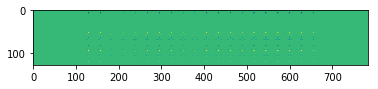

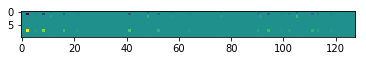

In [12]:
# numpy forward and backward pass

def logsumexp(x):
  #return np.log(np.exp(x).sum(axis=1))
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  c = x.max(axis=1)
  return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
  # training
  out = np.zeros((len(y),10), np.float32)
  out[range(out.shape[0]),y] = 1

  # forward pass
  x_l1 = x.dot(l1)
  x_relu = np.maximum(x_l1, 0)
  x_l2 = x_relu.dot(l2)
  x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
  x_loss = (-out * x_lsm).mean(axis=1)

  # training in numpy (super hard!)
  # backward pass

  # will involve x_lsm, x_l2, out, d_out and produce dx_sm
  d_out = -out / len(y)

  # derivative of logsoftmax
  # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
  dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

  # derivative of l2
  d_l2 = x_relu.T.dot(dx_lsm)
  dx_relu = dx_lsm.dot(l2.T)

  # derivative of relu
  dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

  # derivative of l1
  d_l1 = x.T.dot(dx_l1)
  
  return x_loss, x_l2, d_l1, d_l2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

imshow(d_l1.T)
figure()
imshow(d_l2.T)

loss 0.01 accuracy 0.98: 100%|██████████| 1000/1000 [00:01<00:00, 664.84it/s]


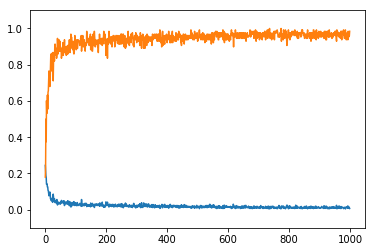

In [14]:
# numpy training
def layer_init(m, h):
  # gaussian is strong
  #ret = np.random.randn(m,h)/np.sqrt(m*h)
  # uniform is stronger
  ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
  return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
t = trange(1000)
for i in (t):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = X_train[samp].reshape((-1, 28*28))
  Y = Y_train[samp]
  x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
  
  cat = np.argmax(x_l2, axis=1)
  accuracy = (cat == Y).mean()
  
  # SGD
  l1 = l1 - lr*d_l1
  l2 = l2 - lr*d_l2
  
  loss = x_loss.mean()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [15]:
# evaluate on test set
# over 96% with numpy, wow numpy is better than pytorch!
# note: add 0.01% more accuracy with float16
numpy_eval()

(10000, 784)
(10000, 128)
(10000, 128)
(10000, 10)


0.9639

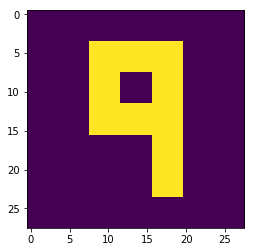

In [20]:
# for fun, can it recognize 4?
m = [[0,0,0,0,0,0,0],
     [0,0,1,1,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
imshow(m.reshape(28,28))

In [21]:
# what is it?
x = m.reshape(1, -1).dot(l1)
x = np.maximum(x, 0)
x = x.dot(l2)
np.argmax(x)

9